


#### Topics: Sparsity (PCA and Compressive Sensing)
#### Assigned: Wednesday May 23
#### Due: Sunday June 10 by midnight



In [1]:
# -*- coding: utf-8 -*-
import numpy as np
from math import *
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm


# Params
N = 2000
dims = 100
ulength = 7

# Code & Logs

## Part I PCA

Generate a random vector u in d dimensions as follows: The components of u are i.i.d., with
- P [u[i] = 0] = 2=3; P [u[i] = +1] = 1=6; P [u[i] = −1] = 1=6




In [2]:
# Generate the IID 
def generateMultiDimGaussian(d, ulength):
    u = np.ndarray((ulength,d))
    angles = np.zeros((ulength,ulength))
    deviation = 10    
    while np.amax(angles+90*np.eye(ulength)) > (90+deviation) or np.amin(angles+90*np.eye(ulength)) < (90-deviation):
        for i in range(ulength):
            for j in range(d):
                r = np.random.rand()
                if(r<4/6):
                    u[i,j] = 0
                elif(r<5/6):
                    u[i,j] = 1
                else:
                    u[i,j] = -1
        if(u.any(axis=1).all()):
            for i in range(ulength):
                for j in range(i):
                    angles[i,j] = np.arccos(  np.clip( np.dot(u[i,:]/np.linalg.norm(u[i,:]), u[j,:]/np.linalg.norm(u[j,:]))  ,-1.0,1.0))/np.pi*180
                    angles[j,i] = angles[i,j]
    #print(angles)
    return u

# Uj be i.i.d
Uj = generateMultiDimGaussian(dims, ulength)
print(Uj.shape)

(7, 100)


Generate d-dimensional data samples for a Gaussian mixture distribution with 3 equiprobable components
1. Zm  : Standard Gaussian (N(0, 1)) distribution
2. N   : noise vector" N ∼ N(0, σ2Id) (default value σ2 = 0:01)
3. Component 1: Generate X = u1 + Z1u2 + Z2u3 + N.
4. Component 2: Generate X = 2u4 + sqrt(2)Z1u5 + Z2u6 + N.
5. Component 3: Generate X = sqrt(2)u6 + Z1(u1 + u2) + (1/sqrt(2))Z2u5 + N

In [3]:

""" 
Generate the higher dimension dataset and sample equiprobable from components
"""
def generateDataset(u, num_data = 50, d = 30):
    sigma_sq = 0.01
    #print('\nX(Nxd):',num_data,"x",d,',\tUj:',Uj[0].shape)
    dataset = np.ndarray((num_data,d))
    labels  = np.zeros((num_data,3))  # will be containing [0,1,0] one hot value    
    # Assign the values based on the three component function
    for i in range(0, num_data):
        # Random numbers Zm {Z1, Z2} and N are drawn afresh
        Z1 = np.random.normal()
        Z2 = np.random.normal()
        noise = np.random.multivariate_normal(np.zeros(d), (sigma_sq)*np.eye(d))  
        # choose which comnponent to pick from 
        idx_comp = np.random.choice([0, 1, 2],1,p=[0.333, 0.333, 0.334])
        if(idx_comp == 0):   # Sample from component 1
            dataset[i,:] = Uj[1,:] + Z1*Uj[2,:] + Z2*Uj[3,:] + noise
        elif(idx_comp == 1): # Sample from component 3
            dataset[i,:] = 2*Uj[4,:] + np.sqrt(2)*Z1*Uj[5,:] + Z2*Uj[6,:] + noise
        elif(idx_comp == 2): # Sample from component 3
            dataset[i,:] = np.sqrt(2)*Uj[6,:] + Z1*(Uj[1,:] + Uj[2,:]) + 1/np.sqrt(2) *Z2*Uj[5,:] + noise
        # Assign a label
        labels[i,idx_comp]=1
    return dataset, labels

#X_data, Y_hot_labels = generateDataset(Uj, 50, 30)
#print("> X: Data Set:",X_data.shape,", Y: One hot :",Y_hot_labels.shape)

### 1. SVD of the A(N × d) data matrix 

A = U SIGMA V<sup>T</sup>

1. V must diagonalize A<sup>T</sup>A and v<sub>i</sub> are eigenvectors of A<sup>T</sup>A.
2. SIGMA where SIGMA<sub>ii</sub> are singular values of A. 
3. U must diagonalize AA<sup>T</sup> and u<sub>i</sub> are eigenvectors of AA<sup>T</sup> 

> X: Data Set: (50, 100) , Y: One hot : (50, 3)
> SD-inp: 1.2425699236269871 
SD-out: 1.242569923626987 
SD-Err: 3.048454173224238e-15
Singular values  50 × 100  :  [48.39048927 43.11330642 41.06337937 33.16084801 21.96589821 15.14612167
  1.5994595 ]
> X: Data Set: (60, 100) , Y: One hot : (60, 3)
> SD-inp: 1.3498319267986385 
SD-out: 1.3498319267986376 
SD-Err: 3.4819962065686176e-15
Singular values  60 × 100  :  [55.31684119 53.0200592  44.0650705  39.84964441 30.09112566 24.50793065
  1.69841237]
> X: Data Set: (80, 100) , Y: One hot : (80, 3)
> SD-inp: 1.1498704791356968 
SD-out: 1.1498704791356964 
SD-Err: 1.806028648889445e-15
Singular values  80 × 100  :  [57.5893642  53.216893   40.83616548 33.89971405 28.80635373 27.18518553
  1.76064902]
> X: Data Set: (100, 100) , Y: One hot : (100, 3)
> SD-inp: 1.2997668301927499 
SD-out: 1.2997668301927496 
SD-Err: 4.440394990401163e-15
Singular values  100 × 100  :  [69.90863454 62.67001101 54.6252193  50.84244765 38.22080618 31.71841843

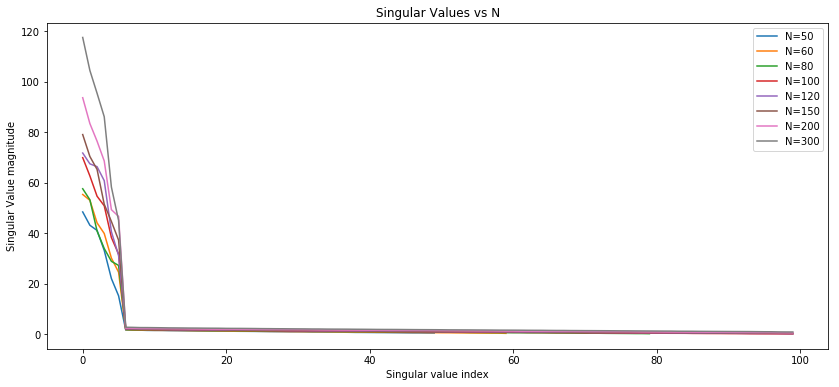

In [4]:
# input sample N=? from components 
def getSingularValues(N = 50, d=30):
    X_data, Y_hot_labels = generateDataset(Uj, N, d)
    print("> X: Data Set:",X_data.shape,", Y: One hot :",Y_hot_labels.shape)
    #Xt = X_data.T
    U, S, V = np.linalg.svd(X_data, full_matrices=False)
    X_a = np.dot(np.dot(U, np.diag(S)), V)
    print("> SD-inp:", np.std(X_data), "\nSD-out:", np.std(X_a), "\nSD-Err:",np.std(X_data - X_a))
    print("Singular values ",N,"×",d," : ",S[0:7])
    return S

plt.figure(figsize=(14,6))
plt.title('Singular Values vs N')
plt.xlabel('Singular value index')
plt.ylabel('Singular Value magnitude')

for Num in [50, 60, 80, 100, 120, 150, 200, 300]:
    S = getSingularValues(Num, dims)
    plt.plot(range(len(S)), S,label = str('N='+str(Num)))
plt.legend()
plt.show()
    
    


### 1.(a)  d<sub>0</sub> = 6 are the dominant singular values
##### we can see this based on the variation for N = [50, 60, 80, 100, 120, 150, 200, 300]



### Now, project the data down to the dominant d0 components to obtain an N × d0 data matrix.

In [5]:

X_data, Y_hot_labels = generateDataset(Uj, N, dims)
print("> X: Data Set:",X_data.shape,", Y: One hot :",Y_hot_labels.shape)
U, S, V = np.linalg.svd(X_data, full_matrices=False)
X_a = np.dot(np.dot(U, np.diag(S)), V)
print(">\nSD-inp:", np.std(X_data), "\nSD-out:", np.std(X_a), "\nSD-Err:",np.std(X_data - X_a))
print("Singular values ",N,"×",dims," : ",S[0:7])


d0 = 6 # Dominant vectors d0 = 6 
print("Singular: ", np.diag(S[:d0]).shape)
reconst_matrix = np.dot(U[:,:d0],np.dot(np.diag(S[:d0]),V[:d0,:]))
print(">\nSD-inp:", np.std(X_data), "\nSD-out:", np.std(reconst_matrix), "\nSD-Err:",np.std(X_data - reconst_matrix))


# Using eigen vector V as the basis for projecting the data 
evecs = V[:, :d0]
X_reduced_matrix = np.dot(X_data, evecs)
print("Reduced Matrix[From =",N,"×",dims,"]:" ," To =",X_reduced_matrix.shape)
#print(X_reduced_matrix)

> X: Data Set: (2000, 100) , Y: One hot : (2000, 3)
>
SD-inp: 1.2395057807174528 
SD-out: 1.2395057807174528 
SD-Err: 1.7785550318342964e-15
Singular values  2000 × 100  :  [282.76080712 266.71486558 242.47285716 229.01120717 161.32588682
 133.6358575    5.38798619]
Singular:  (6, 6)
>
SD-inp: 1.2395057807174528 
SD-out: 1.235722754594632 
SD-Err: 0.09679696927444671
Reduced Matrix[From = 2000 × 100 ]:  To = (2000, 6)


Run on the reduced dimensions data with d0 =  6
Data Dims:  2000 x 6
Dataset  :  (2000, 6)

-------- K= 2 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.00
K= 0 , idx= 1   -> Prob=0.80
K= 0 , idx= 2   -> Prob=0.00
______________________ 

K= 1 , idx= 0   -> Prob=1.00
K= 1 , idx= 1   -> Prob=0.20
K= 1 , idx= 2   -> Prob=1.00

-------- K= 3 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.00
K= 0 , idx= 1   -> Prob=0.30
K= 0 , idx= 2   -> Prob=0.49
______________________ 

K= 1 , idx= 0   -> Prob=1.00
K= 1 , idx= 1   -> Prob=0.00
K= 1 , idx= 2   -> Prob=0.51
______________________ 

K= 2 , idx= 0   -> Prob=0.00
K= 2 , idx= 1   -> Prob=0.70
K= 2 , idx= 2   -> Prob=0.00

-------- K= 4 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.00
K= 0 , idx= 1   -> Prob=0.51
K= 0 , idx= 2   -> Prob=0.00
______________________ 

K= 1 , idx= 0   -> Prob=0.00
K= 1 , idx= 1   -> Prob=0.45
K= 1 , idx= 2   -> Prob=0.00
______________________ 

K= 2 , idx= 0   -> Pro

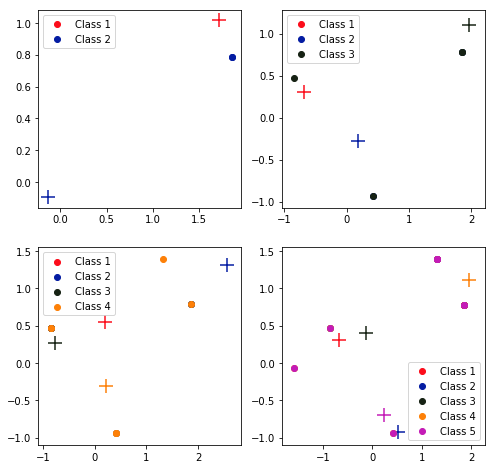

In [47]:
def runKmeansCluster(data, labels, d):
    class_means_dict=dict()
    preds_dict=dict()
    fig = plt.figure(figsize=(8,8))
    subplot_id = 221
    print("Data Dims: ",N,"x",d)
    print("Dataset  : ", data.shape)
    # Kmeans trial 
    for K in range(2,6):
        pred = np.zeros((N, K))
        class_means = np.ndarray((K, d))
        initial_indices = np.random.choice(N,K)

        for k in range(K):
            class_means[k,:] = data[initial_indices[k],:]
        old_class_means = np.zeros((K,d))

        print("\n-------- K=",K,"----------")

        while np.linalg.norm(old_class_means-class_means)/np.linalg.norm(class_means) > 0.001 : 
            norm_mse = np.linalg.norm(old_class_means-class_means)
            norm_mu = np.linalg.norm(class_means)
            #print("> ",norm_mse,"/",norm_mu," \t=\t ",norm_mse/norm_mu)
            old_class_means = np.array(class_means)
            for i in range(N):
                distance_to_means = np.zeros(K)
                for k in range(K):
                    distance_to_means[k] = np.linalg.norm(class_means[k] - data[i])
                #print("Distance: ",distance_to_means)
                nearest_mean = np.argmin(distance_to_means)
                #print("Nearest : ",nearest_mean)
                # labels as the min dist
                pred[i,:] = np.zeros(K)
                pred[i, nearest_mean] = 1 # one hot encoding

            # new mean
            for k in range(K):
                class_means[k] = np.mean(data[np.where(pred[:,k]==1)], axis=0)
            #print("Class MU : ",class_means)
        ax = fig.add_subplot(subplot_id)
        subplot_id = subplot_id +1
        
        
        for k in range(K):
            colors = ('#fc0d1b','#041ca2','#162214','#fd8008','#c41bb6')
            ax.scatter(data[np.where(pred[:k] == 1),0], data[np.where(pred[:k] == 1),1], color = colors[k], label = ('Class %d' % (k+1)))
            ax.scatter(class_means[k,0], class_means[k,1], s=200, marker='+', color = colors[k])
        ax.legend()
        #plt.savefig('dim_%d_q1_%d_means.png' % (d,K), dpi=600)
        #plt.show 
        
        # save means
        class_means_dict[K] = class_means
        preds_dict[K] = pred
        probabilities = np.ndarray((3,K))  

        for predicted in range(K):
            print('______________________ \n')
            for true_label in range(3):
                interssect = np.intersect1d(np.where(labels[:, true_label] == 1), np.where(pred[:, predicted] == 1))
                tots = np.where(labels[:, true_label] == 1)[0]
                #print('K=',predicted,", idx=",true_label,"\nP -> ",interssect,"\nT ->", tots)
                probabilities[true_label, predicted] = len(interssect) / len(tots)  
                print('K=',predicted,", idx=",true_label,'  -> Prob=%.2f' % probabilities[true_label, predicted])
    fig.show
print("Run on the reduced dimensions data with d0 = ", d0)
runKmeansCluster(X_reduced_matrix, Y_hot_labels, d0)

## Part II : Random Projections and Compressed Sensing

## 3.
#####  (a.) Generate m x d matrix Φ, IID drawn such as P [Φij = +1] = 1/2; P [Φij = −1] = 1/2
#####  (b.) Compressive Projection,  y = 1/sqrt(m) * ( Φ x ) with sparse reconstruction of s based on y


In [7]:
def generatePhiMatrix(m, d):
    u = np.ndarray((m,d))
    for i in range(m):
        for j in range(d):
            r = np.random.rand()
            if(r<1/2):
                u[i,j] = 1
            else:
                u[i,j] = -1
    #print("Φ(mxd):",u.shape)
    return u

def getCompressedProjection(m, d, log=False):
    # Keeping dimensions as dimensions d = 30 and number of data N = 50
    Xp_data, Zp_hot_labels = generateDataset(Uj, N, d)
    # Generate Phi
    phi = generatePhiMatrix(m,d)
    # Compressive Projection (m-dim projection of the d-dim matrix x)
    Y_xp =  (1/np.sqrt(m)) * np.matmul(Xp_data, phi.T)        
    B = np.transpose(Uj)
    if(log == True):
        print("> N =",N,", M =",m,", Y_xp:", Y_xp.shape, ", Labels:",Zp_hot_labels.shape, ", Phi :",phi.shape, ", B :",B.shape)
    return Xp_data, Y_xp, Zp_hot_labels, phi, B

M = 20
X, Y_xp, labels, phi, B_evecs = getCompressedProjection(M, dims, True)

> N = 2000 , M = 20 , Y_xp: (2000, 20) , Labels: (2000, 3) , Phi : (20, 100) , B : (100, 7)


### 4. Lasso problem (using sklearn.linear_model.Lasso)

- Φ(phi) = projection matrix also called A in examples 
- x = latent data variables with gaussian noise 
- y = observed results (projection matrix is applied on latent data variables and the result has been reduced in dimensions)

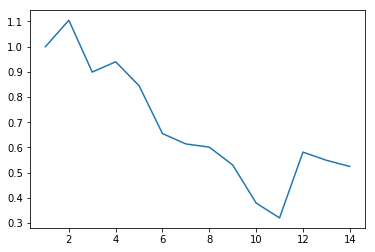

The minimum M is  11


In [11]:


from sklearn import linear_model

def normalizedME(s, s_hat):
     return np.linalg.norm(s_hat - s)/np.linalg.norm(s)

def findMinimumM():
    mses = []
    # Keeping dimension fixed and varying M for this
    rng = range(1,15)
    for m in rng:  
        s, Y_xp, labels, phi, B = getCompressedProjection(m, dims, False)
        matrix = (1/np.sqrt(m)) * np.matmul(phi, B)
        clf = linear_model.Lasso(alpha = 1.0) # Set lambda ( called ’alpha ’ here )
        clf.fit(matrix, Y_xp.T) # Fit the reduced Y to the one hot
        a_hat = clf.coef_ # Get a_hat
        s_hat = np.matmul(a_hat, B.T) # this is the output
        #print("Mat:",matrix.shape, ",\ts_hat:",s_hat.shape, ",\ts:",s.shape)
        mses.append(normalizedME(s, s_hat))  
    plt.plot(list(rng), mses)
    plt.show()
    return np.argmin(mses)+1

minM = findMinimumM()
print("The minimum M is ", minM)

### 5. Normalized MSE vs Lambda

In [37]:

def normalize(lst):
    s = sum(lst)
    return map(lambda x: float(x)/s, lst)

def mean(lst):
    return sum(lst)/float(len(lst))

def normalizedMSE(s, s_hat):
     return (np.linalg.norm(s_hat - s)/np.linalg.norm(s))**2

def computeMSELambda(N, m, d):
    mse_ = []
    mse_comp1_ = []
    mse_comp2_ = []
    mse_comp3_ = []
    s, Y_xp, labels, phi, B = getCompressedProjection(m, d, False)
    matrix = (1/np.sqrt(m)) * np.matmul(phi, B)
    clf = linear_model.Lasso(alpha = 1.0) # Set lambda ( called ’alpha ’ here )
    clf.fit(matrix, Y_xp.T) # Fit the reduced Y to the one hot
    a_hat = clf.coef_ # Get a_hat
    s_hat = np.matmul(a_hat, B.T) # this is the output
    for i in range(N):
        mse = normalizedMSE(s[i],s_hat[i])
        index = np.where(labels[i]==1)[0]
        if index == 0: #component 1
            mse_comp1_.append(mse)
        if index == 1:
            mse_comp2_.append(mse)
        if index == 2:
            mse_comp3_.append(mse)
        mse_.append(mse)
    return mean(mse_), mean(mse_comp1_),mean(mse_comp2_),mean(mse_comp3_)


mse_list=[]
mse_comp1_list = []
mse_comp2_list = []
mse_comp3_list = []

lambda_list = [0.05,0.07,0.08,0.09,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for l in lambda_list:
    me, me1, me2, me3 = computeMSELambda(N, minM, dims)
    mse_list.append(me)
    mse_comp1_list.append(me1)
    mse_comp2_list.append(me2)
    mse_comp3_list.append(me3)
    

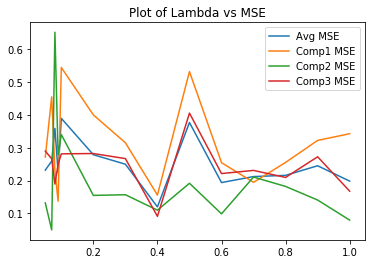

In [38]:
plt.title('Plot of Lambda vs MSE')
plt.plot(lambda_list, mse_list, label="Avg MSE")
plt.plot(lambda_list, mse_comp1_list, label="Comp1 MSE")
plt.plot(lambda_list, mse_comp2_list, label="Comp2 MSE")
plt.plot(lambda_list, mse_comp3_list, label="Comp3 MSE")
plt.legend()
plt.show()

### 6. Compare the Euclidean distances squared vs the corresponding quantity in projected space


In [39]:
m = minM
J = 6
B = np.transpose(Uj)
projected_u = (1/np.sqrt(m)) * np.matmul(phi, B)
projected_dist_matrix = np.zeros(shape=(J,J))
for i in range(J):
    for j in range(J):
        dist = np.linalg.norm(projected_u[:,i]-projected_u[:,j])**2
        projected_dist_matrix[i][j] =  dist  
print("projected_dist_matrix\n",projected_dist_matrix)
dist_matrix = np.zeros(shape=(J,J))
for i in range(J):
    for j in range(J):
        dist = np.linalg.norm(Uj[:,i]-Uj[:,j])**2
        dist_matrix[i][j] =  dist 
print("dist_matrix\n",dist_matrix)

projected_dist_matrix
 [[  0.    37.45  56.36  73.45  23.64  46.82]
 [ 37.45   0.    66.91  66.55  34.91  87.55]
 [ 56.36  66.91   0.   131.27  59.64 114.45]
 [ 73.45  66.55 131.27   0.    70.18  67.18]
 [ 23.64  34.91  59.64  70.18   0.    43.18]
 [ 46.82  87.55 114.45  67.18  43.18   0.  ]]
dist_matrix
 [[ 0.  2.  2.  7.  3.  4.]
 [ 2.  0.  2.  3.  3.  2.]
 [ 2.  2.  0.  7.  3.  4.]
 [ 7.  3.  7.  0. 10.  7.]
 [ 3.  3.  3. 10.  0.  7.]
 [ 4.  2.  4.  7.  7.  0.]]


### 7. K-means algorithm post-projection

Data Dims:  2000 x 11
Dataset  :  (2000, 11)

-------- K= 2 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.69
K= 0 , idx= 1   -> Prob=0.63
K= 0 , idx= 2   -> Prob=0.27
______________________ 

K= 1 , idx= 0   -> Prob=0.31
K= 1 , idx= 1   -> Prob=0.37
K= 1 , idx= 2   -> Prob=0.73

-------- K= 3 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.00
K= 0 , idx= 1   -> Prob=0.43
K= 0 , idx= 2   -> Prob=0.08
______________________ 

K= 1 , idx= 0   -> Prob=0.31
K= 1 , idx= 1   -> Prob=0.02
K= 1 , idx= 2   -> Prob=0.66
______________________ 

K= 2 , idx= 0   -> Prob=0.69
K= 2 , idx= 1   -> Prob=0.55
K= 2 , idx= 2   -> Prob=0.26

-------- K= 4 ----------
______________________ 

K= 0 , idx= 0   -> Prob=0.23
K= 0 , idx= 1   -> Prob=0.01
K= 0 , idx= 2   -> Prob=0.57
______________________ 

K= 1 , idx= 0   -> Prob=0.03
K= 1 , idx= 1   -> Prob=0.30
K= 1 , idx= 2   -> Prob=0.01
______________________ 

K= 2 , idx= 0   -> Prob=0.00
K= 2 , idx= 1   -> Prob=0.39
K= 2 , idx

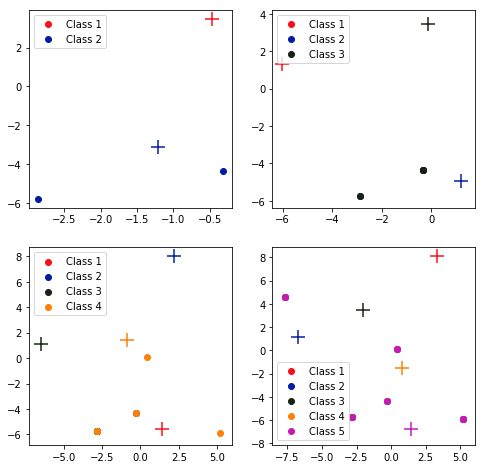

In [48]:
x, labels = generateDataset(Uj, N, dims)
phi = generatePhiMatrix(minM,dims)
Y = np.matmul(phi,np.transpose(x))/(np.sqrt(minM))
Z = np.transpose(Y)
runKmeansCluster(Z,labels, minM)


### 8. Geometric insights

### END